In [1]:
import numpy as np
import pickle
import pandas as pd
import agents.scripts as scripts
import aws.sqs as d_sqs
import boto3
from tqdm import tqdm
import matplotlib.pyplot as plt

from caveclient import CAVEclient
client = CAVEclient("minnie65_phase3_v1")
ts = client.materialize.get_timestamp(117)

In [2]:
gt = pd.read_pickle("./ground_truth_dendrite_extension.pkl")
run_on = gt.iloc[-1]
root_id = scripts.get_public_seg_ids(run_on.seg_id)[0]
extensions = scripts.get_public_seg_ids(run_on.extensions)
coords = list(run_on.annotations)

In [3]:
coords = [[int(c) for c in co] for co in coords]

In [5]:
from caveclient import CAVEclient
from intern import array
import pickle
import numpy as np
from agents import data_loader
from cloudvolume import CloudVolume
from membrane_detection import membranes
import agents.sensor
from agents.run import run_agents
import aws.sqs as sqs
import sys
import time
def drive(n, radius=(200,200,20), resolution=(8,8,40), unet_bound_mult=2, ep='sqs', save='sqs',device='cpu',
          cnn_weights='thick',filter_merge=True,delete=True, endp=(0,0,0), nucleus_id=0, root_id=0, time_point=0):

    vol = CloudVolume("s3://bossdb-open-data/iarpa_microns/minnie/minnie65/em", use_https=True, mip=0)
    resolution = [int(x) for x in resolution]
    radius = [int(x) for x in radius]
    unet_bound_mult = float(unet_bound_mult)
    unet_bound = [int(x*float(unet_bound_mult)) for x in radius]
    n = int(n)
    ep_param = ep
    
    tic1=time.time()
    if ep_param == 'sqs':
        ep_msg = sqs.get_job_from_queue(queue_url_endpts)
        root_id = int(ep_msg.message_attributes['root_id']['StringValue'])
        nucleus_id = int(ep_msg.message_attributes['nucleus_id']['StringValue'])
        time_point = int(ep_msg.message_attributes['time']['StringValue'])
        ep = [float(p) for p in ep_msg.body.split(',')]
        print(root_id, nucleus_id, ep)
        if delete:
            ep_msg.delete()
    else:
        root_id = root_id
        nucleus_id = nucleus_id
        time_point = time_point
        ep = [float(p) for p in endp]
    endpoint = np.divide(ep, resolution).astype('int')
    precomp_file_path = f"./precompute_{root_id}_{endpoint}"
    bound  = (endpoint[0] - radius[0], 
                endpoint[0] + radius[0],
                endpoint[1] - radius[1],
                endpoint[1] + radius[1],
                endpoint[2] - radius[2],
                endpoint[2] + radius[2])

    bound_EM  = (endpoint[0] - unet_bound[0], 
                endpoint[0] + unet_bound[0],
                endpoint[1] - unet_bound[1],
                endpoint[1] + unet_bound[1],
                endpoint[2] - radius[2],
                endpoint[2] + radius[2])
    seg = np.squeeze(data_loader.get_seg(*bound))
    tic = time.time()

    vol = CloudVolume("s3://bossdb-open-data/iarpa_microns/minnie/minnie65/em", use_https=True, mip=0)
    try:
        em = np.squeeze(vol[bound_EM[0]:bound_EM[1], bound_EM[2]:bound_EM[3], bound_EM[4]:bound_EM[5]])
    except OutOfBoundsError:
        print("OOB")
    errors_shift, errors_zero = scripts.shift_detect(em, 100, 1, 1, 10)

#     if cnn_weights == 'thick':
#         mem_seg = membranes.segment_membranes(em, pth="./membrane_detection/best_metric_model_segmentation2d_dict.pth", device_s=device)
#     elif cnn_weights == 'thin':
#         mem_seg = membranes.segment_membranes(em, pth="./membrane_detection/model_CREMI_2D.pth", device_s=device)
    mem_seg = pickle.load(open("./mem_dump.p", "rb"))
    mem_seg = scripts.remove_shifts(mem_seg, errors_shift+errors_zero, zero_or_remove='zero')

    mem_to_run = mem_seg[int((unet_bound_mult-1)*radius[0]):int((unet_bound_mult+1)*radius[0]),
                    int((unet_bound_mult-1)*radius[1]):int((unet_bound_mult+1)*radius[1]), :].astype(float)
    print(f"Seg time: {time.time() - tic}")
    tic = time.time()

    compute_vectors = scripts.precompute_membrane_vectors(mem_to_run, mem_to_run, precomp_file_path, 3)
    print(f"Convolution time: {time.time() - tic}")

    sensor_list = [
        (agents.sensor.BrownianMotionSensor(), .1),
        (agents.sensor.PrecomputedSensor(), .2),
        (agents.sensor.MembraneSensor(mem_to_run), 0),
        ]

    pos_histories, seg_ids, agent_ids, soma, polarities=run_agents(mem=mem_to_run, sensor_list=sensor_list,
                                                precompute_fn=precomp_file_path+'.npz',
                                                max_vel=.9,n_steps=250,segmentation=seg,
                                                root_id=root_id, endpoint_nm=ep)
    # find merges of agents from root_id
    pos_matrix, merge_d = scripts.create_post_matrix(pos_histories, seg, mem_to_run.shape, merge=True)
    merges = scripts.position_merge(ep, root_id, merge_d, soma, polarities)
#     merges = scripts.merge_paths(pos_histories,seg_ids, ep, root_id, soma, polarities)
    if merges.shape[0] > 0:
        client = CAVEclient('minnie65_phase3_v1')
        #merges.to_csv(f"./merges_root_{root_id}_{endpoint}.csv")
        seg_ids = [int (x) for x in merges.Extension]

        weights = [int(x) for x in merges.Weight]
        weights_dict = dict(zip(seg_ids, weights))
    else:
        weights_dict = {}
    if save == "pd":
        merges.to_csv(f"./merges_{root_id}_{endpoint}.csv")
    return mem_seg, merges, pos_matrix, seg_ids, em, seg

In [8]:
found = []
rank = []
weight_pct = []
merge_list = []
for i in range(len(coords)):
    mem_seg, merges, pos_matrix, seg_ids, em, seg = drive(1, radius=(100,100,10), 
          resolution=(2,2,1), unet_bound_mult=2, ep='None', save='pd', device='cpu',
          endp=coords[i], nucleus_id='none', root_id=root_id, time_point=0)
    if merges.shape[0] > 0:
        merge_sort = merges.sort_values("Weight",ascending=False).reset_index(drop=True)
        m_rank = merge_sort[merge_sort.Extension.astype(int).isin(extensions)]
        if m_rank.shape[0]  > 0:
            rank.append(m_rank.index[0])
            found.append(True)
            weight_pct.append(m_rank.iloc[0].Weight / np.sum(merges.Weight))
        else:
            found.append(False)
            rank.append(-1)
            weight_pct.append(0)            
    else:
        found.append(False)
        rank.append(-1)
        weight_pct.append(-1)
    merge_list.append(merges)
    

Decompressing: 100%|██████████████████████████| 32/32 [00:00<00:00, 1206.49it/s]


Seg time: 1.562467098236084
Convolution time: 0.05805015563964844


/Users/joycejm1/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/joycejm1/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


303 agents spawned

Agent Spawning Prep Time 7.9003520011901855
Steps Time 2.239842176437378


Decompressing: 100%|██████████████████████████| 40/40 [00:00<00:00, 1074.61it/s]


Seg time: 2.2224440574645996
Convolution time: 0.06784486770629883
219 agents spawned

Agent Spawning Prep Time 8.995017766952515
Steps Time 1.4003798961639404


Decompressing: 100%|██████████████████████████| 32/32 [00:00<00:00, 1013.97it/s]


Seg time: 2.12454891204834
Convolution time: 0.05688595771789551


/Users/joycejm1/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/joycejm1/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


234 agents spawned

Agent Spawning Prep Time 10.05735182762146
Steps Time 1.841284990310669


Decompressing: 100%|███████████████████████████| 60/60 [00:00<00:00, 938.31it/s]


Seg time: 2.610684871673584
Convolution time: 0.06714010238647461


/Users/joycejm1/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/joycejm1/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


147 agents spawned

Agent Spawning Prep Time 8.89652395248413
Steps Time 1.0397312641143799


Decompressing: 100%|███████████████████████████| 32/32 [00:00<00:00, 861.23it/s]


Seg time: 2.082634925842285
Convolution time: 0.058925628662109375


/Users/joycejm1/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/joycejm1/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


27 agents spawned

Agent Spawning Prep Time 8.824236154556274
Steps Time 0.21069693565368652


Decompressing: 100%|███████████████████████████| 40/40 [00:00<00:00, 787.17it/s]


Seg time: 4.086798191070557
Convolution time: 0.05592703819274902
105 agents spawned

Agent Spawning Prep Time 8.34193205833435
Steps Time 0.7264277935028076


Decompressing: 100%|███████████████████████████| 40/40 [00:00<00:00, 946.01it/s]


Seg time: 2.0315418243408203
Convolution time: 0.06273412704467773
45 agents spawned

Agent Spawning Prep Time 10.743171215057373
Steps Time 0.3121192455291748


Decompressing: 100%|██████████████████████████| 40/40 [00:00<00:00, 1052.57it/s]


Seg time: 2.5660998821258545
Convolution time: 0.05519294738769531
166 agents spawned

Agent Spawning Prep Time 9.659725189208984
Steps Time 1.1157641410827637


Decompressing: 100%|███████████████████████████| 32/32 [00:00<00:00, 787.83it/s]


Seg time: 2.2204580307006836
Convolution time: 0.057692766189575195
91 agents spawned

Agent Spawning Prep Time 10.495877265930176
Steps Time 0.7297070026397705


Decompressing: 100%|███████████████████████████| 32/32 [00:00<00:00, 831.23it/s]


Seg time: 3.207509994506836
Convolution time: 0.0574190616607666


/Users/joycejm1/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/joycejm1/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


173 agents spawned

Agent Spawning Prep Time 11.774986028671265
Steps Time 1.4097440242767334


Decompressing: 100%|███████████████████████████| 40/40 [00:00<00:00, 917.75it/s]


Seg time: 2.2520627975463867
Convolution time: 0.05846810340881348
104 agents spawned

Agent Spawning Prep Time 7.920527935028076
Steps Time 0.8635902404785156


Decompressing: 100%|███████████████████████████| 48/48 [00:00<00:00, 948.26it/s]


Seg time: 2.27606201171875
Convolution time: 0.05781698226928711
126 agents spawned

Agent Spawning Prep Time 9.50971007347107
Steps Time 1.074563980102539


Decompressing: 100%|███████████████████████████| 32/32 [00:00<00:00, 847.66it/s]


Seg time: 1.90040922164917
Convolution time: 0.05708599090576172


/Users/joycejm1/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/joycejm1/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


154 agents spawned

Agent Spawning Prep Time 8.856530904769897
Steps Time 0.9311671257019043


In [50]:
merge_df = pd.DataFrame()
for i in range(len(merge_list)):
    m = merge_list[i]
    merge_df = pd.concat([merge_df, m])

In [52]:
merge_df.to_csv("GT_merges.csv")

In [67]:
weights_merge = np.zeros_like(seg)
for i in range(merges.shape[0]):
    mask = np.array(seg) == int(merges.iloc[i].Extension)
    weights_merge[mask] = merges.iloc[i].Weight

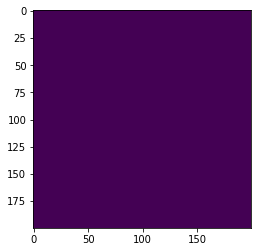

In [68]:
plt.imshow(weights_merge[:,:,10],vmin=0, vmax=500)

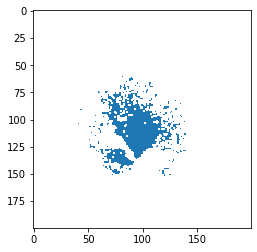

In [72]:
import matplotlib.pyplot as plt
plt.imshow(pos_matrix[:,:,10],cmap='tab20')

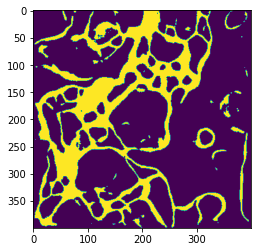

In [12]:
import matplotlib.pyplot as plt
plt.imshow(mem_seg[:,:,11],vmin=0,vmax=1)

In [53]:
merge_list[1]

,EP,Root_id,Extension,Weight
0,"[107125.0, 175763.0, 21958.0]",864691135491236447,864691133746665959,1
1,"[107125.0, 175763.0, 21958.0]",864691135491236447,864691136597419729,5
13,"[107125.0, 175763.0, 21958.0]",864691135491236447,864691135485573015,46
17,"[107125.0, 175763.0, 21958.0]",864691135491236447,864691136591946193,1
24,"[107125.0, 175763.0, 21958.0]",864691135491236447,864691136600365777,4
